In [11]:
import gym
import random
import numpy as np
import tensorflow as tf
import time
from gym.envs.registration import register
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

In [4]:
try:
    register(
        id='FrozenLakeNoSlip-v0',
        entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name' : '4x4', 'is_slippery':False},
        max_episode_steps=100,
        reward_threshold=0.78, # optimum = .8196
    )
except:
    pass

# env_name = "CartPole-v1"
# env_name = "MountainCar-v0"
# env_name = "MountainCarContinuous-v0"
# env_name = "Acrobot-v1"
# env_name = "Pendulum-v0"
#env_name = "FrozenLake-v0"
env_name = "FrozenLakeNoSlip-v0"
env = gym.make(env_name)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
type(env.action_space)


Observation space: Discrete(16)
Action space: Discrete(4)


gym.spaces.discrete.Discrete

In [5]:
class Agent():
    def __init__(self, env):
        self.is_discrete = \
            type(env.action_space) == gym.spaces.discrete.Discrete
        
        if self.is_discrete:
            self.action_size = env.action_space.n
            print("Action size:", self.action_size)
        else:
            self.action_low = env.action_space.low
            self.action_high = env.action_space.high
            self.action_shape = env.action_space.shape
            print("Action range:", self.action_low, self.action_high)
        
    def get_action(self, state):
        if self.is_discrete:
            action = random.choice(range(self.action_size))
        else:
            action = np.random.uniform(self.action_low,
                                       self.action_high,
                                       self.action_shape)
        return action

In [6]:
class QAgent(Agent):
    def __init__(self, env, discount_rate=0.97, learning_rate=0.01):
        super().__init__(env)
        self.state_size = env.observation_space.n
        print("State size:", self.state_size)
        
        self.eps = 1.0
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        self.build_model()
        
    def build_model(self):
        self.q_table = 1e-5*np.random.random([self.state_size, self.action_size])
        
    def get_action(self, state):
        q_state = self.q_table[state]
        action_greedy = np.argmax(q_state)
        action_random = super().get_action(state)
        return action_random if random.random() < self.eps else action_greedy
    
    def train(self, experience):
        state, action, next_state, reward, done = experience
        
        q_next = self.q_table[next_state]
        q_next = np.zeros([self.action_size]) if done else q_next
        q_target = reward + self.discount_rate * np.max(q_next)
        
        q_update = q_target - self.q_table[state,action]
        self.q_table[state,action] += self.learning_rate * q_update
        
        if done:
            self.eps = self.eps * 0.99
        
agent = QAgent(env)

Action size: 4
State size: 16


In [19]:
total_reward = 0
rewards= []
epsilon=[]
Time= []
episodes=[]
for ep in range(101):
    start= time.time()
    state = env.reset()
    done = False
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        agent.train((state,action,next_state,reward,done))
        state = next_state
        total_reward += reward
        env.render()
        
        
        rewards.append(total_reward)
        epsilon.append(agent.eps)
        episodes.append(ep)
        end= time.time()
        time.sleep(0.05)
        clear_output(wait=True)
        Time.append(end-start)

        print(agent.q_table)
        print("s:", state, "a:", action)
        print("Episode: {}, Total reward: {}, eps: {}".format(ep,total_reward,agent.eps))
        
        print('Time taken for 100 episodes to compute is :{} milliseconds'.format(np.sum(Time)))

        

[[  4.71266727e-04   3.32056921e-01   4.44596357e-06   5.76793484e-04]
 [  1.40488244e-03   5.68815892e-07   4.78353780e-06   6.62613309e-06]
 [  5.88808024e-06   4.89115324e-05   6.46726872e-07   8.74106588e-06]
 [  5.99396518e-06   5.54521086e-06   7.55918055e-06   6.55988929e-06]
 [  7.46290218e-05   4.98242969e-01   4.66144470e-06   1.11864627e-05]
 [  8.23328771e-06   2.19933887e-06   3.61799043e-06   4.21727380e-06]
 [  7.34426251e-06   3.03990617e-02   2.15497009e-06   5.31593257e-06]
 [  6.93778477e-06   1.95283671e-06   4.96014042e-06   1.97489426e-06]
 [  5.63522148e-03   3.16187338e-06   6.73588844e-01   3.11773514e-04]
 [  3.23280770e-04   4.47592444e-03   8.25160361e-01   7.95616475e-06]
 [  8.24600434e-03   9.31612904e-01   7.79158337e-06   7.07293722e-04]
 [  3.27440152e-06   5.37985406e-06   5.01783159e-07   4.01251669e-06]
 [  3.45679833e-06   6.76292924e-06   3.95333310e-06   8.68307583e-06]
 [  8.47536907e-06   3.94636186e-04   1.04316737e-01   2.68795318e-06]
 [  4.

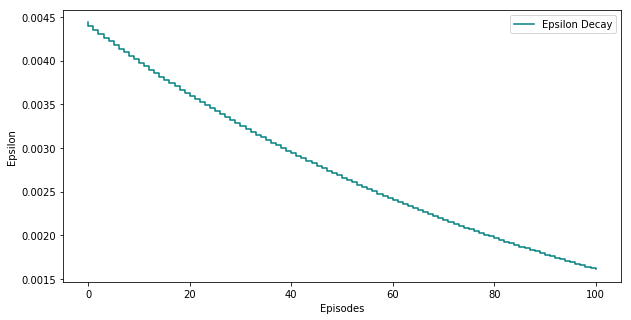

In [20]:
plt.plot(episodes, epsilon, label= 'Epsilon Decay', c= 'teal')

plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.legend(loc=1)

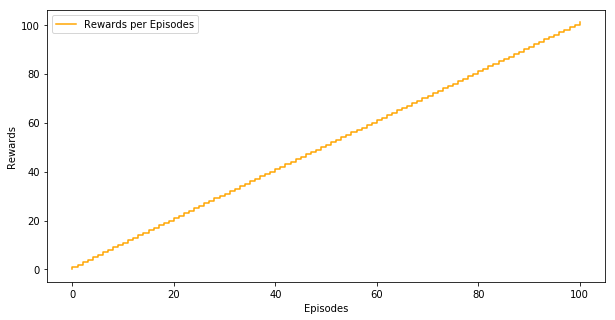

In [21]:
plt.plot(episodes, rewards, label= 'Rewards per Episodes', c= 'orange')

plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend(loc=2)